# Tutorial to implement GAN using PyTorch
This is a simple example to grasp the concept of GAN framework. We will build our version from scratch afterward \
https://realpython.com/generative-adversarial-networks/#handwritten-digits-generator-with-a-gan

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [60]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import torchvision

In [6]:
# Enable GPU if possible

device = "cuda" if torch.cuda.is_available() else "cpu"



# Transform MNIST in tensor with normalized values
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

# Separate tensor into batch for PyTorch
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

## Show some samples

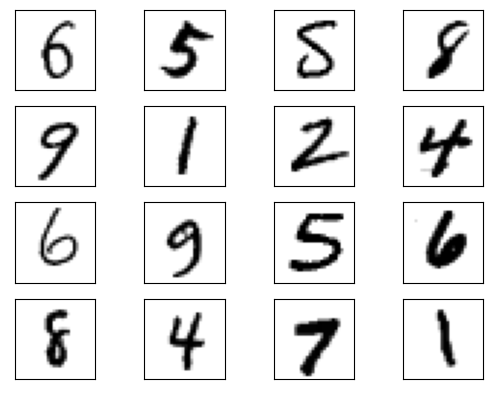

In [4]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Implement Generator & Discriminator

In [69]:
# use CNN

class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(784, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Fully connected layer: Transforms the input noise vector into a feature map
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU()
        )
        
        self.features = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Tanh() # Output pixel values mapped to [-1, 1]
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 7, 7)
        return self.features(x)


discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

### Hyperparameters

In [71]:
lr = 0.0001
lr_generator = 2e-4
lr_discriminator = 1e-4

epoch = 1
num_epochs = 300
loss_function = torch.nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator)

In [37]:
import datetime
import os

def save_images(epoch):
    # save generated samples
    latent_space_samples = torch.randn(batch_size, 100).to(device=device)
    generated_samples = generator(latent_space_samples)

    generated_samples = generated_samples.cpu().detach()

    date_now = datetime.datetime.now()
    folder_id = date_now.strftime("%m")
    folder_id += '.'
    folder_id += date_now.strftime("%d")
    folder_id += '-'
    folder_id += date_now.strftime("%H")
    folder_id += '.'
    folder_id += date_now.strftime("%M")

    # data_dir_path = os.path.join(os.path.dirname(__file__), "data", folder_id)
    # if not os.path.exists(folder_id):
    #     os.mkdir(folder_id)

    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    plt.savefig(f'{folder_id}_epoch{epoch}.png')
    plt.close()

### Train models using GAN framework

In [78]:
import numpy as np

# Data for training the discriminator
real_samples = real_samples.to(device=device)
real_samples_labels = 0.9*torch.ones((batch_size, 1)).to(
    device=device
) # label smoothing

# num_epochs = 500
for epoch in range(epoch, num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):       
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = 0.1*torch.ones((batch_size, 1)).to(
            device=device
        ) # label smoothing

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
#         if n == batch_size - 1:
#             print(f"Epoch: {epoch}")
#             print(f" Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f" Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")

    if epoch % 50 == 0:
        save_images(epoch)
        
        
torch.save({
    'epoch': epoch,
    'discriminator_state_dict': discriminator.state_dict(),
    'generator_state_dict': generator.state_dict(),
    'optimizer_D_state_dict': optimizer_discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_generator.state_dict(),
    'loss_D': loss_discriminator,
    'loss_G': loss_generator,
}, 'checkpoint.pth')            

save_images(epoch)

print("model and image saved")


Epoch: 300
 Loss D.: 0.62903892993927, Loss G.: 1.0278664827346802


KeyboardInterrupt: 

In [79]:
# load model status
checkpoint = torch.load('checkpoint.pth', weights_only=False)
epoch = checkpoint['epoch']
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator.load_state_dict(checkpoint['generator_state_dict'])
optimizer_discriminator.load_state_dict(checkpoint['optimizer_D_state_dict'])
optimizer_generator.load_state_dict(checkpoint['optimizer_G_state_dict'])
loss_D = checkpoint['loss_D']
loss_G = checkpoint['loss_G']

epoch

299